# Beacon, Fitbit, and EMA Analysis
We look at the BIG three and see what things we can see when considering multiple modalities.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Initial Exploration
The start to a more complex analysis, here we just look through the data we have for the combined modalities.

In [9]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd

pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import itertools

# Data Import

## Evening IAQ Data
We start by importing the IAQ data from the beacon that has been restricted fully by Fitbit and EMAs

In [48]:
beacon = pd.read_csv('../data/processed/beacon-fb_ema_and_gps_filtered-ux_s20.csv',
                                    index_col=0,parse_dates=['timestamp','start_time','end_time'],infer_datetime_format=True)
beacon = beacon[["start_time","end_time","tvoc","lux","no2","co","co2","pm2p5_mass","temperature_c","rh","beacon","redcap","beiwe"]]
beacon.head()

,start_time,end_time,tvoc,lux,no2,co,co2,pm2p5_mass,temperature_c,rh,beacon,redcap,beiwe
timestamp,,,,,,,,,,,,,
2020-08-10 05:10:00,2020-08-10 04:42:30,2020-08-10 12:35:30,184.700000,2.04,1.576607,10.742600,1816.486399,1.831140,24.0,33.183333,21,12,lkkjddam
2020-08-10 05:15:00,2020-08-10 04:42:30,2020-08-10 12:35:30,164.000000,2.04,1.593896,10.678200,1795.248137,1.878851,24.0,33.000000,21,12,lkkjddam
2020-08-10 05:20:00,2020-08-10 04:42:30,2020-08-10 12:35:30,152.433333,2.04,1.590097,10.676133,1763.231375,1.652677,24.0,33.000000,21,12,lkkjddam
2020-08-10 05:25:00,2020-08-10 04:42:30,2020-08-10 12:35:30,159.150000,2.04,1.585059,10.703900,1724.723961,1.497815,24.0,33.050000,21,12,lkkjddam
2020-08-10 05:30:00,2020-08-10 04:42:30,2020-08-10 12:35:30,143.933333,2.04,1.598890,10.667433,1772.028385,2.056448,24.0,32.983333,21,12,lkkjddam


## Morning EMAs
We also want the actual EMA data from the sleep surveys

In [12]:
ema = pd.read_csv('../data/processed/beiwe-morning_ema-ux_s20.csv',
                  index_col=0,parse_dates=True,infer_datetime_format=True)
ema.head()

,beiwe,content,stress,lonely,sad,energy,tst,sol,naw,restful,redcap,beacon
timestamp,,,,,,,,,,,,
2020-05-13 09:10:27,qh34m4r9,3,0.0,0.0,0.0,1.0,8.0,20.0,2.0,3.0,68,19.0
2020-05-13 09:15:49,awa8uces,0.0,2.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,28,26.0
2020-05-13 09:42:19,xxvnhauv,1,1.0,1.0,3.0,0.0,6.0,30.0,3.0,1.0,21,22.0
2020-05-13 09:43:27,rvhdl2la,1,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0,29,NaN
2020-05-13 10:11:51,q5y11ytm,3,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,48,NaN


## Fitbit Sleep Stages
We also need the recorded Fitbit data.

In [13]:
fitbit = pd.read_csv('../data/processed/fitbit-sleep_stages-ux_s20.csv',
                     index_col='time',parse_dates=['time','start_date','end_date'],infer_datetime_format=True)
fitbit.head()

,start_date,end_date,stage,time_at_stage,beiwe,value
time,,,,,,
2020-05-14 00:27:00,2020-05-14,2020-05-14,wake,510,hfttkth7,0
2020-05-14 00:35:30,2020-05-14,2020-05-14,light,420,hfttkth7,1
2020-05-14 00:42:30,2020-05-14,2020-05-14,deep,1590,hfttkth7,2
2020-05-14 01:09:00,2020-05-14,2020-05-14,light,1290,hfttkth7,1
2020-05-14 01:30:30,2020-05-14,2020-05-14,rem,840,hfttkth7,3


# Visualization

In [14]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

## Nightly Time Series
We want to look at a nice time series that shows some pollutant concentrations, the sleep stages, and when the survey was submitted.

Before that, a cursory analysis shows that we have to consider nights when we have both the beacon and EMA response the next day.

### Checking Survey and IAQ Overlap

In [32]:
def check_overlap(beacon_df, ema_df, pt="4i7679py", by_var="beiwe", var="co2"):
    iaq_pt = beacon_df[beacon_df[by_var] == pt]
    ema_pt = ema_df[ema_df[by_var] == pt]
    fig,ax = plt.subplots(figsize=(16,4))
    ax.scatter(iaq_pt.index,iaq_pt[var],color='seagreen')
    for i in range(len(ema_pt)):
        ax.axvline(ema_pt.index[i],color='black',linestyle='dashed')

    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)

    plt.show()
    plt.close()

In [57]:
beacon["beiwe"].unique()

array(['lkkjddam', 'itmylz3g', 'zdpffrox', 'qh34m4r9', 'tmexej5v',
       'xlw5ntd5', 'kyj367pi', '745vq78e', 'awa8uces', 'vr9j5rry',
       'olaxadz5', 'rnse61g4', '4i7679py', '9jtzsuu8', 'xdbdrk6e',
       'i31pt4b4', 'hxj6brwj', 'tlmlq19s', '9xmhtq74'], dtype=object)

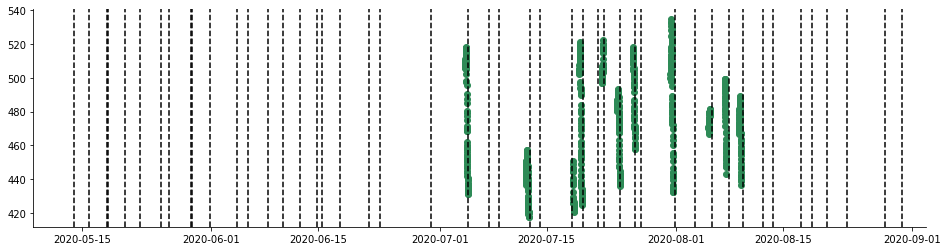

In [33]:
check_overlap(beacon,ema)

### Comprehensive Look
The figure below is by no means a final product, but usable in illustrator for a final edition.

In [34]:
def create_cmap(colors,nodes):
    cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
    return cmap

In [323]:
def plot_nightly_hm(beacon_df, ema_df, fitbit_df, pt="lkkjddam", specify_day=False, target_day="2020-7-13", save=False):
    """plots all nightly ieq parameters and sleep stages"""
    # restricting to patient
    iaq_pt = beacon[beacon['beiwe'] == pt]
    iaq_pt.dropna(inplace=True)
    ema_pt = ema[ema['beiwe'] == pt]
    fb_pt = fitbit[fitbit['beiwe'] == pt]
    for i in range(len(ema_pt)):
        iaq_pt_night = iaq_pt[iaq_pt['end_time'].dt.date == ema_pt.index[i]]
        fb_pt_night = fb_pt[fb_pt['end_date'].dt.date == ema_pt.index[i]]
        if len(iaq_pt_night['co2']) > 0 and len(iaq_pt_night['co']) > 0 and len(iaq_pt_night['no2']) > 0 and len(fb_pt_night) > 0:
            # target a specific day
            #if specify_day:
            #if ema_pt.index[i].date() == datetime(2020,7,13).date():
            ss_wide = pd.DataFrame(data={'time':fb_pt_night.index,'value':fb_pt_night['value']})
            ss_wide.set_index('time',inplace=True)
            ss_wide = ss_wide.resample('5T').ffill()
            iaq_ss = pd.merge(right=iaq_pt_night,left=ss_wide,right_index=True,left_index=True,how='inner')
            iaq_ss = iaq_ss[['co2','pm2p5_mass','no2','co','tvoc','temperature_c',"rh",'lux','value']]
            iaq_ss.index = pd.to_datetime(iaq_ss.index)
            # getting extra time after
            #new_index = pd.date_range(iaq_ss.index[0],datetime(fb_pt_night["end_date"][0].year,fb_pt_night["end_date"][0].month,fb_pt_night["end_date"][0].day,9),freq="5T")
            #temp = pd.DataFrame(index=new_index)
            #iaq_ss = iaq_ss.merge(right=temp,left_index=True,right_index=True,how="outer")
            #return iaq_ss
            
            ylabels = ['CO$_2$','PM$_{2.5}$','NO$_2$','CO',"TVOC",'Temperature',"RH",'Light Level','Sleep Stage']
            cbar_ticks = [np.arange(400,2800,600),np.arange(0,18,5),np.arange(0,8,2),np.arange(0,27,9),np.arange(0,800,200),np.arange(20,30,4),np.arange(40,80,10),np.arange(0,240,60),np.arange(0,4,1)]
            cmaps = [create_cmap(["green", "yellow", "orange", "red",],[0.0, 0.33, 0.89, 1]),
                     create_cmap(["green", "yellow", "orange","red"],[0.0, 0.5, 0.8, 1]),
                     create_cmap(["green", "yellow", "orange","red"],[0.0, 0.42, 0.83, 1]),
                     create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.25, 0.5, 1]),
                     create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.17, 0.43, 1]),
                     create_cmap(["cyan","blue", "green", "orange", "red"],[0.0, 0.375, 0.56, 0.75, 1]),
                     create_cmap(["red", "orange","green", "blue"],[0.0, 0.33,  0.5, 1]),
                     create_cmap(["black","purple","red","orange","yellow","white"],[0.0, 0.056, 0.28, 0.56, 0.83, 1]),
                     'Blues']
            fig, axes = plt.subplots(len(ylabels),figsize=(16,14),sharex=True,gridspec_kw={"hspace":0.5})
            for ax, var, low, high, ylabel, ticks, cmap in zip(axes,iaq_ss.columns,[400,0,0,0,0,20,40,0,0],[2200,15,6,18,600,28,70,180,3],ylabels,cbar_ticks,cmaps):
                sns.heatmap(iaq_ss[[var]].T,vmin=low,vmax=high,ax=ax,cbar_kws={'ticks':ticks,"pad":0.02,"aspect":5},cmap=cmap)
                ax.set_ylabel("")#ylabel,fontsize=16)
                ax.tick_params(axis='y', which='both', left=False,right=False, labelleft=False)
                ax.set_xlabel('')
                ax.set_title(ylabel,loc="left",fontsize=14,pad=4)
                
            # x-axis
            locs = ax.get_xticks()
            labels = ax.get_xticklabels()
            new_xlabels = []
            for label in labels:
                new_xlabels.append(datetime.strptime(label.get_text()[11:16],"%H:%M"))
                
            ax.set_xticks(np.arange(locs[0], locs[-1], 10))
            ax.set_xticklabels(pd.date_range(new_xlabels[0],new_xlabels[-1],periods=11).strftime("%H:%M"),fontsize=14,rotation=-30,ha="left")
            
            if save:
                d = iaq_ss.index[0].strftime("%m%d%Y")
                plt.savefig(f'../reports/figures/all/beacon_ema_fitbit-{pt}_{d}_nightly_summary-heatmap.pdf')
            plt.show()
            plt.close()
            

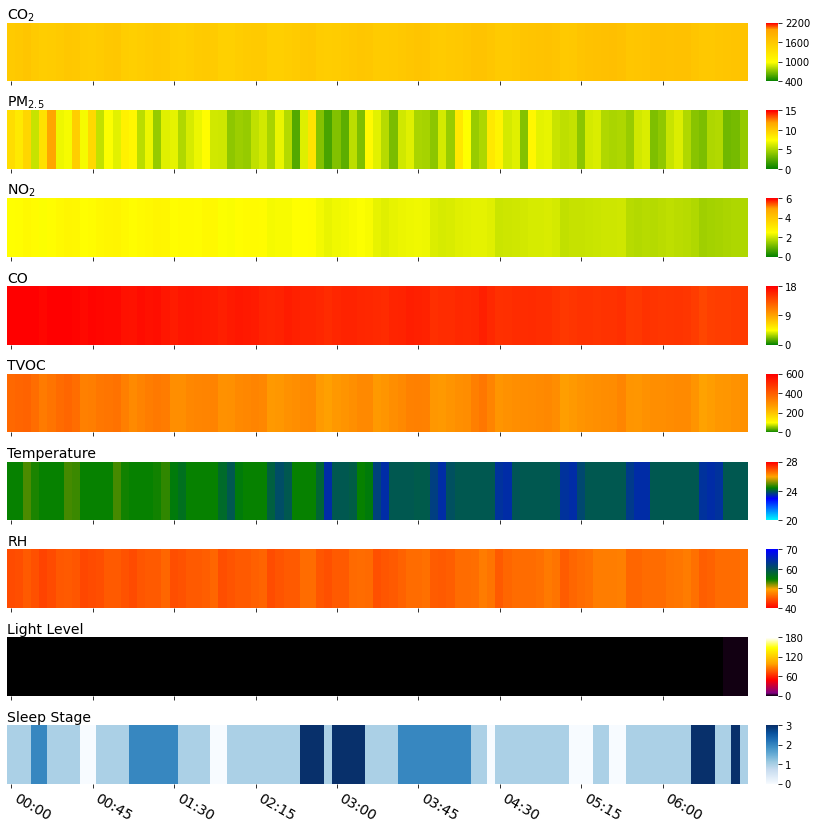

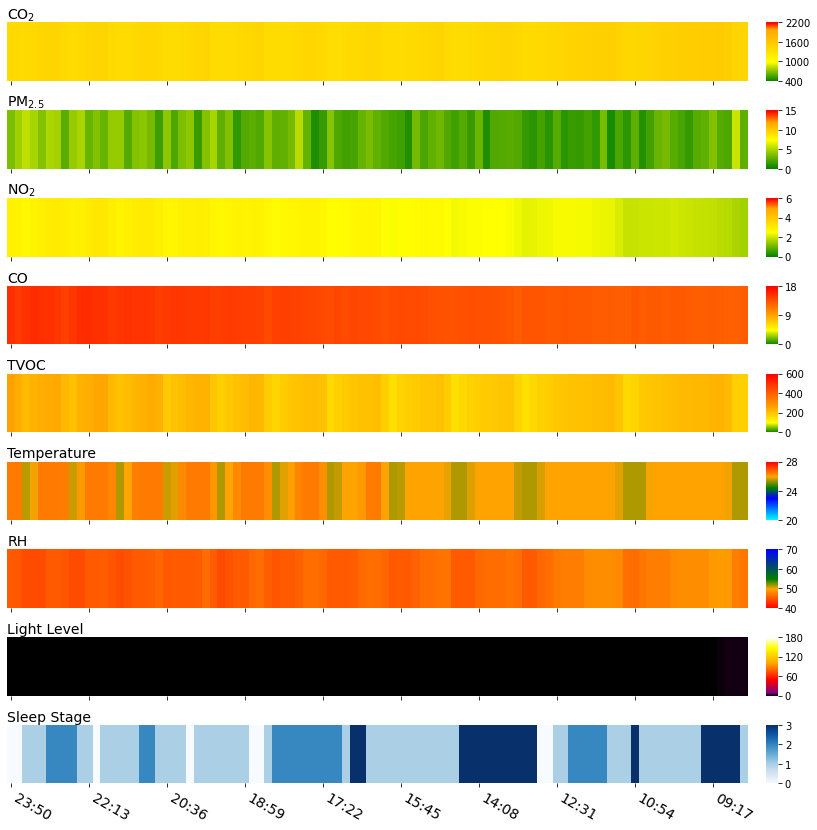

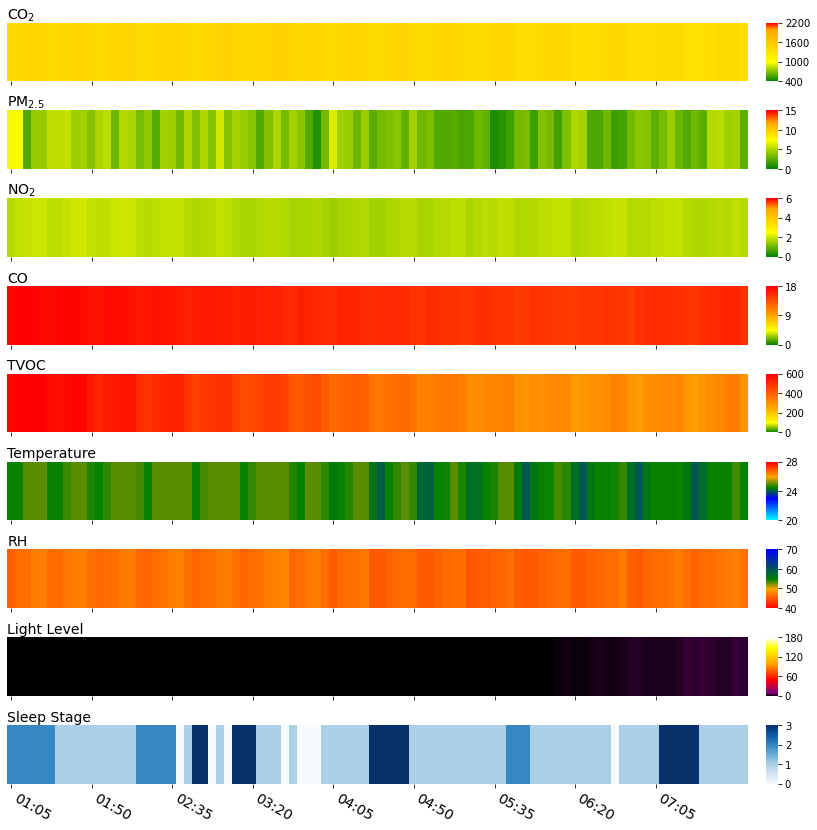

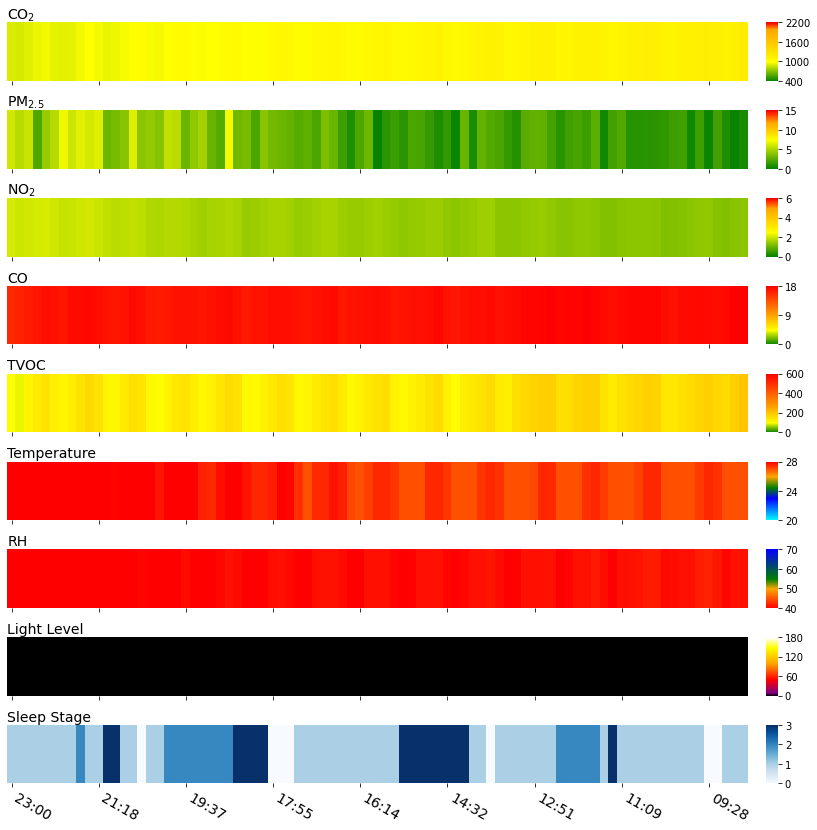

IndexError: index 0 is out of bounds for axis 0 with size 0

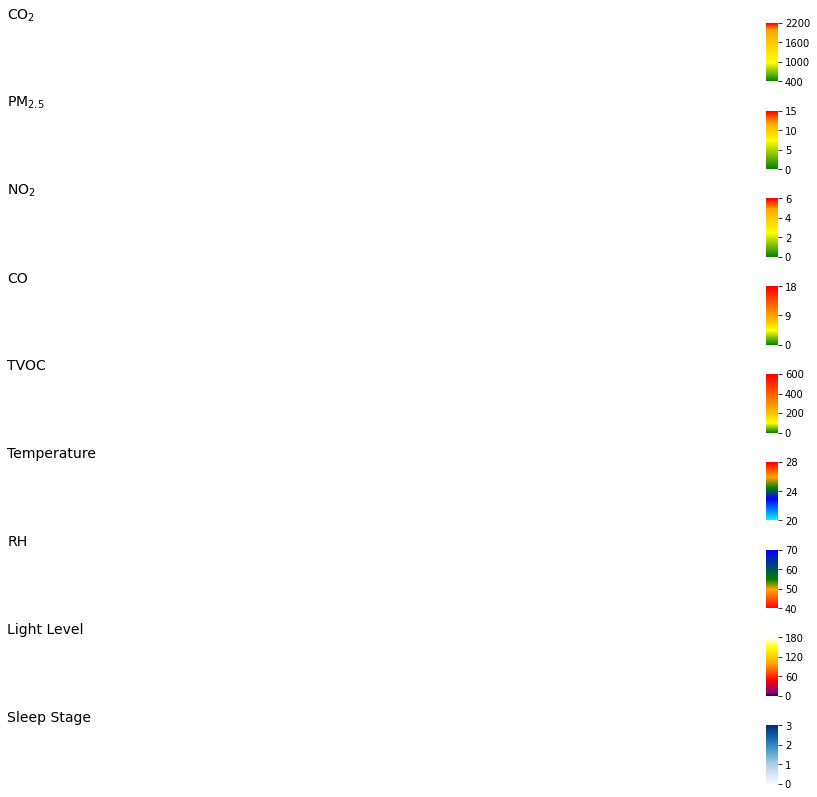

In [322]:
plot_nightly_hm(beacon,ema,fitbit,pt="zdpffrox",save=True)

In [402]:
def plot_nightly_ts(beacon_df, ema_df, fitbit_df, pt="lkkjddam", specify_day=False, target_day="2020-7-13", save=False):
    """plots all nightly ieq parameters and sleep stages"""
    # restricting to patient
    iaq_pt = beacon[beacon['beiwe'] == pt]
    iaq_pt.dropna(inplace=True)
    ema_pt = ema[ema['beiwe'] == pt]
    fb_pt = fitbit[fitbit['beiwe'] == pt]
    for i in range(len(ema_pt)):
        iaq_pt_night = iaq_pt[iaq_pt['end_time'].dt.date == ema_pt.index[i]]
        fb_pt_night = fb_pt[fb_pt['end_date'].dt.date == ema_pt.index[i]]
        if len(iaq_pt_night['co2']) > 0 and len(iaq_pt_night['co']) > 0 and len(iaq_pt_night['no2']) > 0 and len(fb_pt_night) > 0:
            # target a specific day
            #if specify_day:
            #if ema_pt.index[i].date() == datetime(2020,7,13).date():
            ss_wide = pd.DataFrame(data={'time':fb_pt_night.index,'value':fb_pt_night['value']})
            ss_wide.set_index('time',inplace=True)
            ss_wide = ss_wide.resample('5T').ffill()
            iaq_ss = pd.merge(right=iaq_pt_night,left=ss_wide,right_index=True,left_index=True,how='inner')
            iaq_ss = iaq_ss[['co2','pm2p5_mass','no2','co','tvoc','temperature_c',"rh",'lux','value']]
            iaq_ss.index = pd.to_datetime(iaq_ss.index)
            # getting extra time after
            #new_index = pd.date_range(iaq_ss.index[0],datetime(fb_pt_night["end_date"][0].year,fb_pt_night["end_date"][0].month,fb_pt_night["end_date"][0].day,9),freq="5T")
            #temp = pd.DataFrame(index=new_index)
            #iaq_ss = iaq_ss.merge(right=temp,left_index=True,right_index=True,how="outer")
            #return iaq_ss
            
            ylabels = ['CO$_2$','PM$_{2.5}$','NO$_2$','CO',"TVOC",'Temperature',"RH",'Light Level','Sleep Stage']
            cbar_ticks = [np.arange(400,2800,600),np.arange(0,18,5),np.arange(0,8,2),np.arange(0,27,9),np.arange(0,800,200),np.arange(20,30,4),np.arange(40,80,10),np.arange(0,240,60),np.arange(0,4,1)]
            cmaps = [create_cmap(["green", "yellow", "orange", "red",],[0.0, 0.33, 0.89, 1]),
                     create_cmap(["green", "yellow", "orange","red"],[0.0, 0.5, 0.8, 1]),
                     create_cmap(["green", "yellow", "orange","red"],[0.0, 0.42, 0.83, 1]),
                     create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.25, 0.5, 1]),
                     create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.17, 0.43, 1]),
                     create_cmap(["cyan","blue", "green", "orange", "red"],[0.0, 0.375, 0.56, 0.75, 1]),
                     create_cmap(["red", "orange","green", "blue"],[0.0, 0.33,  0.5, 1]),
                     create_cmap(["black","purple","red","orange","yellow","white"],[0.0, 0.056, 0.28, 0.56, 0.83, 1]),
                     'Blues']
            fig, axes = plt.subplots(len(ylabels),figsize=(16,14),sharex=True,gridspec_kw={"hspace":0.5})
            for ax, var, low, high, ylabel, ticks, cmap in zip(axes,iaq_ss.columns,[400,0,0,0,0,20,40,0,0],[2200,15,6,18,600,28,70,180,3],ylabels,cbar_ticks,cmaps):
                if ylabel == "Sleep Stage":
                    iaq_ss["pos"] = 2
                    iaq_ss_shifted = iaq_ss.shift(-1)
                    iaq_ss["pos"] = 1
                    #print(iaq_ss.reset_index())
                    ss = iaq_ss.append(iaq_ss_shifted).reset_index().sort_values(["index","pos"]).dropna()
                    ax.plot(ss["index"],ss[var])
                    ax.set_ylim([-0.5,3.5])
                    ax.set_yticks([0,1,2,3])
                else:
                    ax.plot(iaq_ss.index,iaq_ss[var])
                    ax.set_yticks(ticks)
                    ax.set_ylim([ticks[0],ticks[-1]])
                    
                ax.set_ylabel("")#ylabel,fontsize=16)
                #ax.tick_params(axis='y', which='both', left=False,right=False, labelleft=False)
                ax.set_xlabel('')
                ax.set_title(ylabel,loc="left",fontsize=14,pad=4)
                
            # x-axis
            
            # 
            
            if save:
                d = iaq_ss.index[0].strftime("%m%d%Y")
                plt.savefig(f'../reports/figures/all/beacon_ema_fitbit-{pt}_{d}_nightly_summary-timeseries.pdf')
            plt.show()
            plt.close()
            

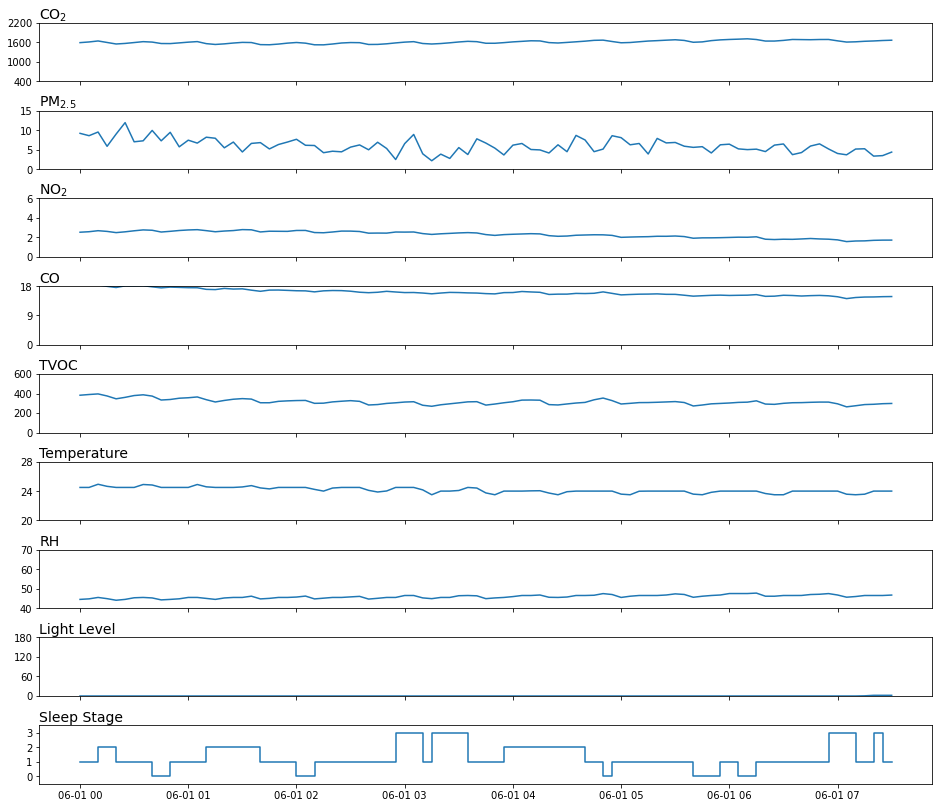

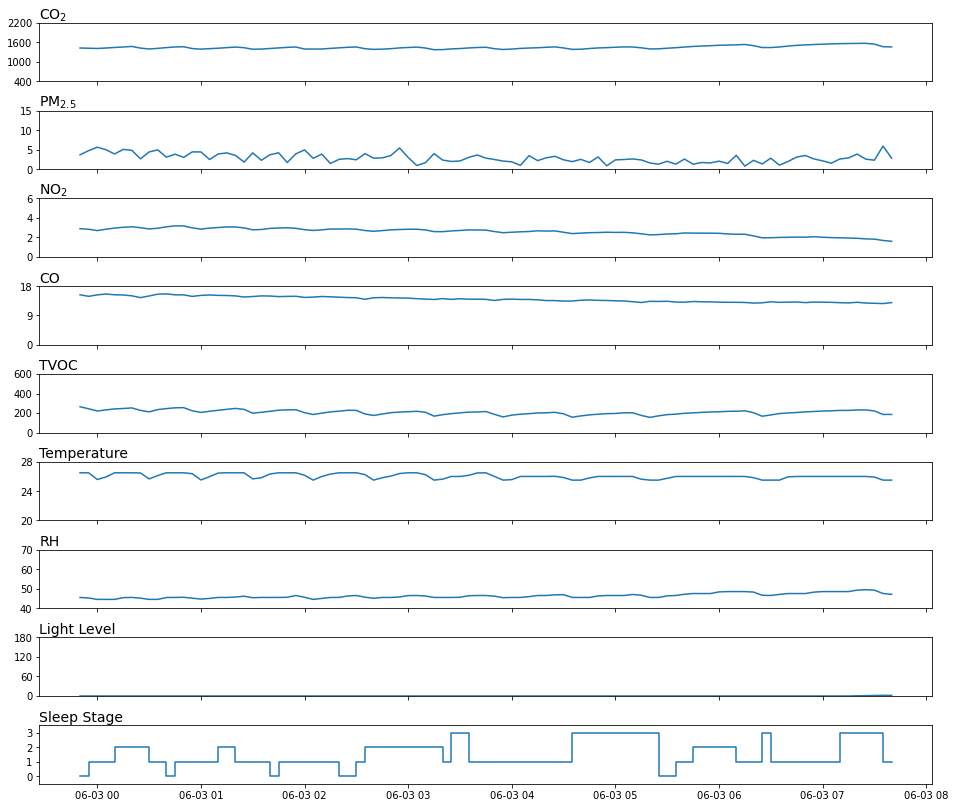

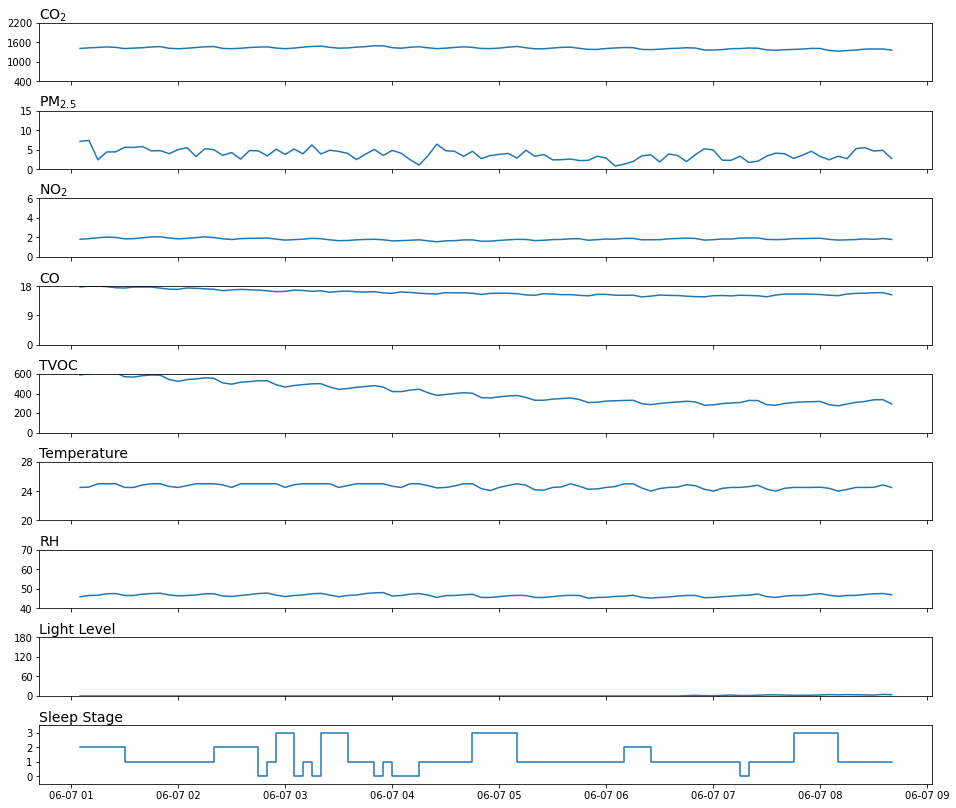

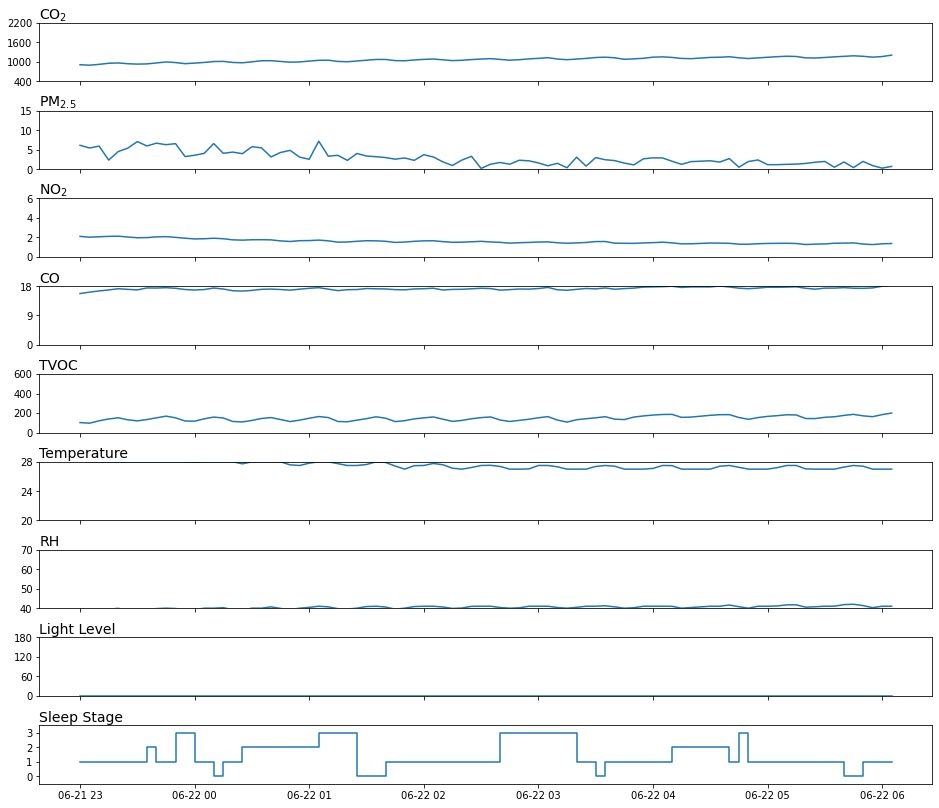

IndexError: index 0 is out of bounds for axis 0 with size 0

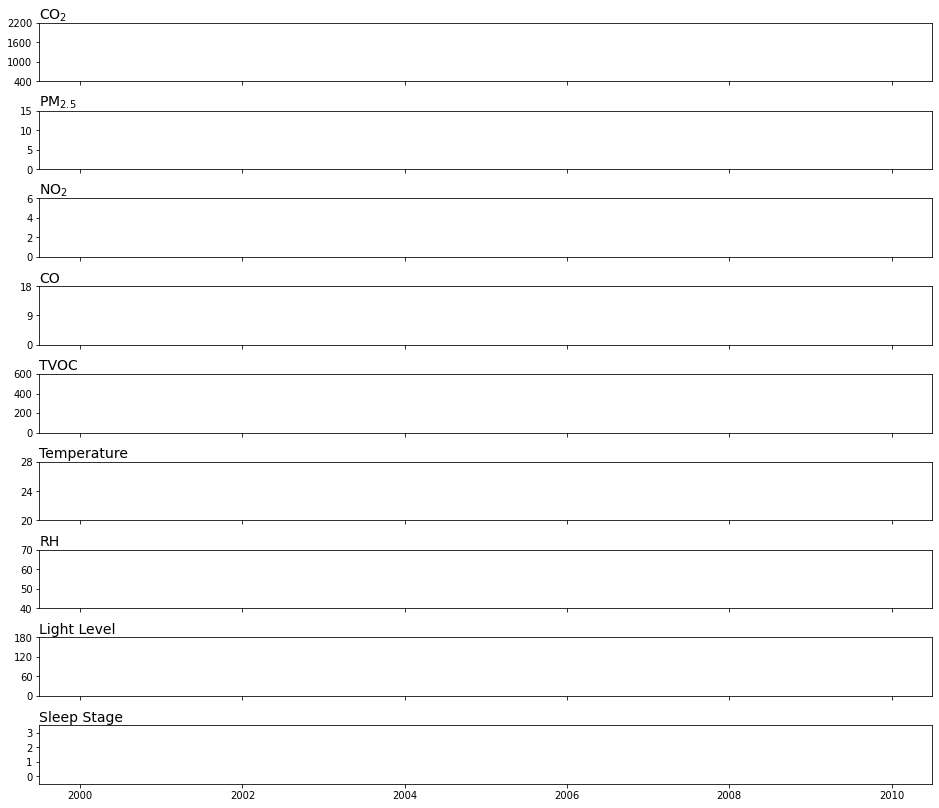

In [404]:
temp = plot_nightly_ts(beacon,ema,fitbit,pt="zdpffrox",save=True)

In [398]:
temp

,index,co2,pm2p5_mass,no2,co,tvoc,temperature_c,rh,lux,value,pos
0,2020-06-01 00:00:00,1588.967740,9.168323,2.531995,18.626100,382.600000,24.500000,44.500000,0.00,1.0,1.0
91,2020-06-01 00:00:00,1609.625735,8.564989,2.584110,18.572950,389.850000,24.500000,44.775000,0.00,1.0,2.0
1,2020-06-01 00:05:00,1609.625735,8.564989,2.584110,18.572950,389.850000,24.500000,44.775000,0.00,1.0,1.0
92,2020-06-01 00:05:00,1640.470371,9.504053,2.688340,18.427067,396.000000,24.933333,45.500000,0.00,1.0,2.0
2,2020-06-01 00:10:00,1640.470371,9.504053,2.688340,18.427067,396.000000,24.933333,45.500000,0.00,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
88,2020-06-01 07:20:00,1640.472010,3.330458,1.700528,14.691833,289.766667,24.000000,46.500000,2.04,1.0,1.0
179,2020-06-01 07:20:00,1654.267182,3.458337,1.720663,14.780500,295.700000,24.000000,46.500000,2.04,3.0,2.0
89,2020-06-01 07:25:00,1654.267182,3.458337,1.720663,14.780500,295.700000,24.000000,46.500000,2.04,3.0,1.0
180,2020-06-01 07:25:00,1663.243148,4.362547,1.724216,14.817333,298.166667,24.000000,46.716667,2.04,1.0,2.0


#### Some Summary Info

In [ ]:
print(f'TST: {iaq_ss.index[-1] - iaq_ss.index[0]}')

In [ ]:
ema_pt['date'] = ema_pt.index.date
ema_pt[ema_pt['date'] == datetime(2020,7,13).date()]

The survey says 7.5 hours and 1 awakening while Fitbit says 8.2 hours and 2 awakenings (don't count the last awakening).